# Step 6: Optimization

In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


# Custom utils functions
from utils.visualization import show_train_val_confusion_matrix
from utils.visualization import visualize_training

## 1. Training

In [2]:
df_train = pd.read_csv("../data/processed_train.csv")
df_test = pd.read_csv("../data/processed_test.csv")

# Separate our features (X) and target (y)
df_X = df_train.drop(["Sepsis"], axis=1)
df_y = df_train[["Sepsis"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (625, 8)
train_y shape: (625, 1)
val_X shape: (157, 8)
val_y shape: (157, 1)


In [3]:
tree_params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
}

base_clf_tree = DecisionTreeClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0  # Reproducible result
)

tree_clf = GridSearchCV(
    base_clf_tree,
    tree_params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
tree_clf.fit(train_X, train_y.values.ravel())

GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-2,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                         'min_samples_split': array([2, 4, 6, 8])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [4]:
tree_clf.best_params_

{'max_depth': 10, 'min_samples_split': 2}

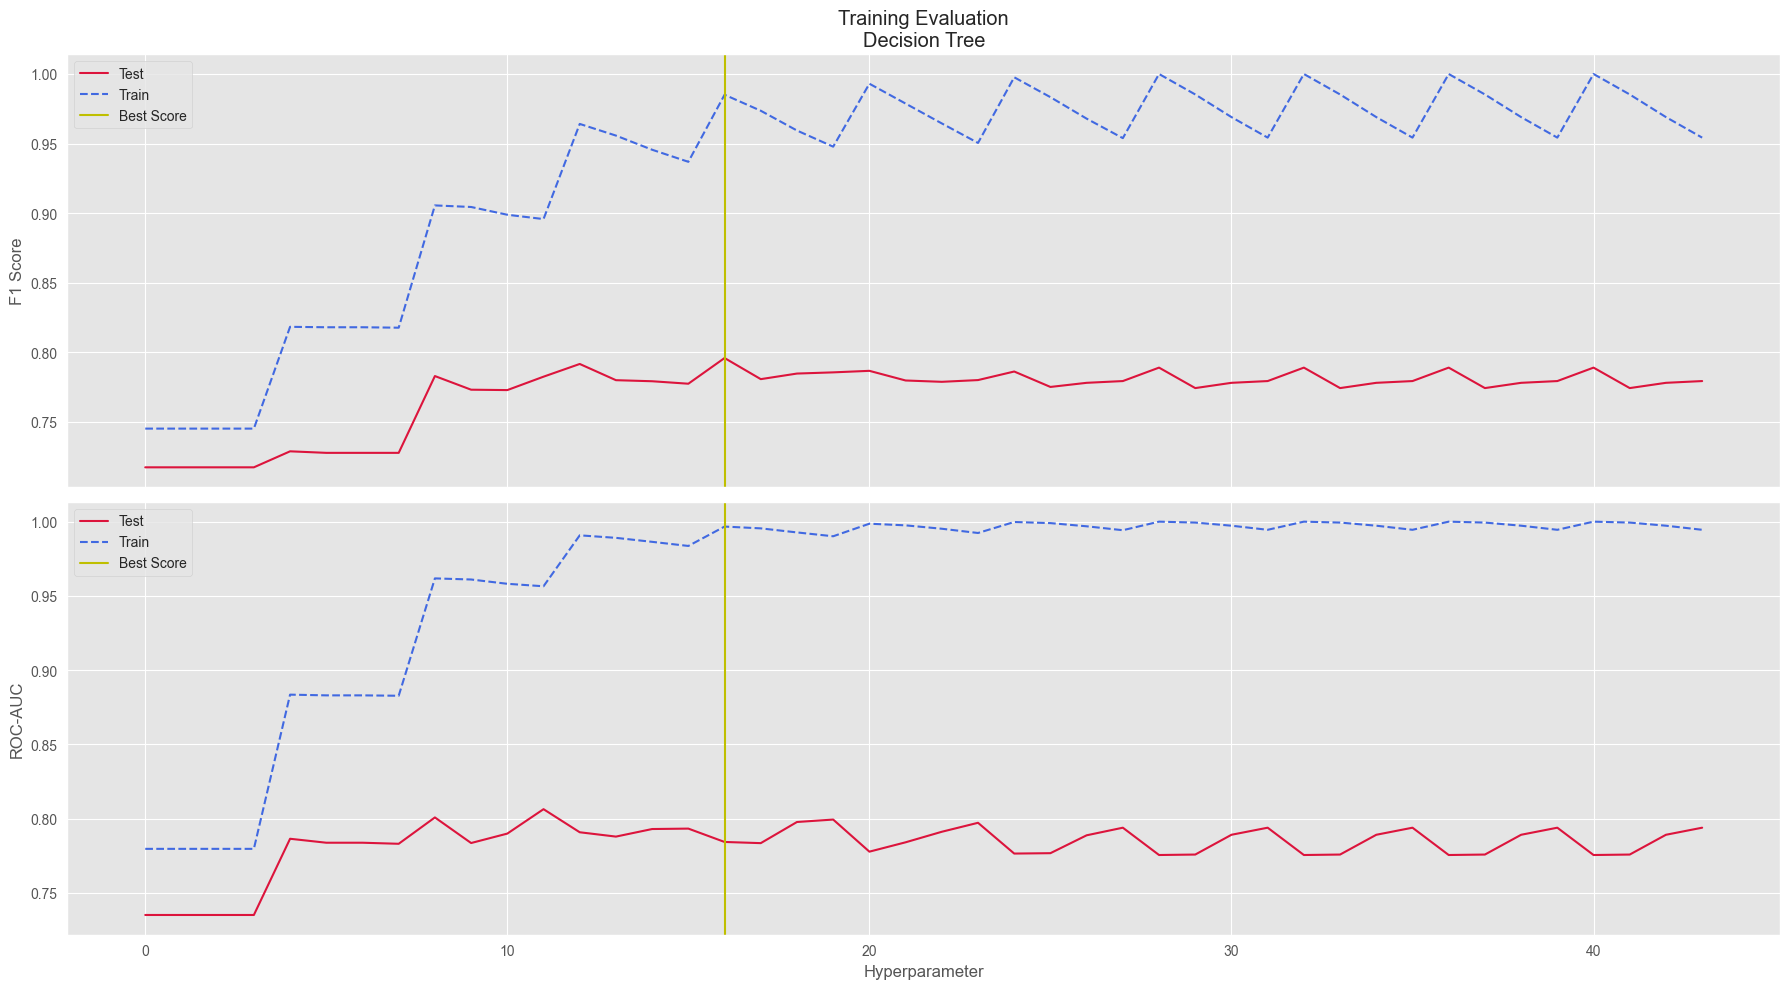

In [5]:
visualize_training(tree_clf, "Training Evaluation\nDecision Tree", "../images/Optimization_Tree_TrainValCompare.png")

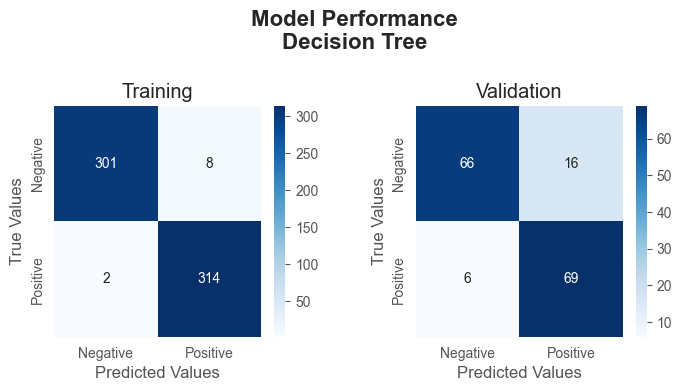

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       309
         1.0       0.98      0.99      0.98       316

    accuracy                           0.98       625
   macro avg       0.98      0.98      0.98       625
weighted avg       0.98      0.98      0.98       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86        82
         1.0       0.81      0.92      0.86        75

    accuracy                           0.86       157
   macro avg       0.86      0.86      0.86       157
weighted avg       0.87      0.86      0.86       157



In [6]:
train_pred_y = tree_clf.predict(train_X)
val_pred_y = tree_clf.predict(val_X)
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nDecision Tree", "../images/Optimization_Tree_CM.png")

In [7]:
column_names = df_X.columns
feature_importances = pd.DataFrame(tree_clf.best_estimator_.feature_importances_, index = column_names, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,importance
PL,0.262781
M11,0.164214
PR,0.163277
BD2,0.128309
PRG,0.126832
Age,0.066298
SK,0.049209
TS,0.039081


[Text(0.46821905339805825, 0.9545454545454546, 'PL <= 0.09\ngini = 0.5\nsamples = 625\nvalue = [312.5, 312.5]\nclass = PRG'),
 Text(0.2999089805825243, 0.8636363636363636, 'PRG <= 0.913\ngini = 0.407\nsamples = 291\nvalue = [209.345, 83.07]\nclass = PRG'),
 Text(0.2503033980582524, 0.7727272727272727, 'PR <= 1.028\ngini = 0.315\nsamples = 231\nvalue = [187.095, 45.491]\nclass = PRG'),
 Text(0.20934466019417475, 0.6818181818181818, 'BD2 <= 1.841\ngini = 0.255\nsamples = 203\nvalue = [173.948, 30.657]\nclass = PRG'),
 Text(0.19963592233009708, 0.5909090909090909, 'Age <= 0.878\ngini = 0.237\nsamples = 200\nvalue = [173.948, 27.69]\nclass = PRG'),
 Text(0.12742718446601942, 0.5, 'BD2 <= 0.961\ngini = 0.186\nsamples = 180\nvalue = [162.824, 18.79]\nclass = PRG'),
 Text(0.055825242718446605, 0.4090909090909091, 'PR <= -2.161\ngini = 0.114\nsamples = 145\nvalue = [137.54, 8.9]\nclass = PRG'),
 Text(0.019417475728155338, 0.3181818181818182, 'TS <= 0.383\ngini = 0.471\nsamples = 13\nvalue = [8

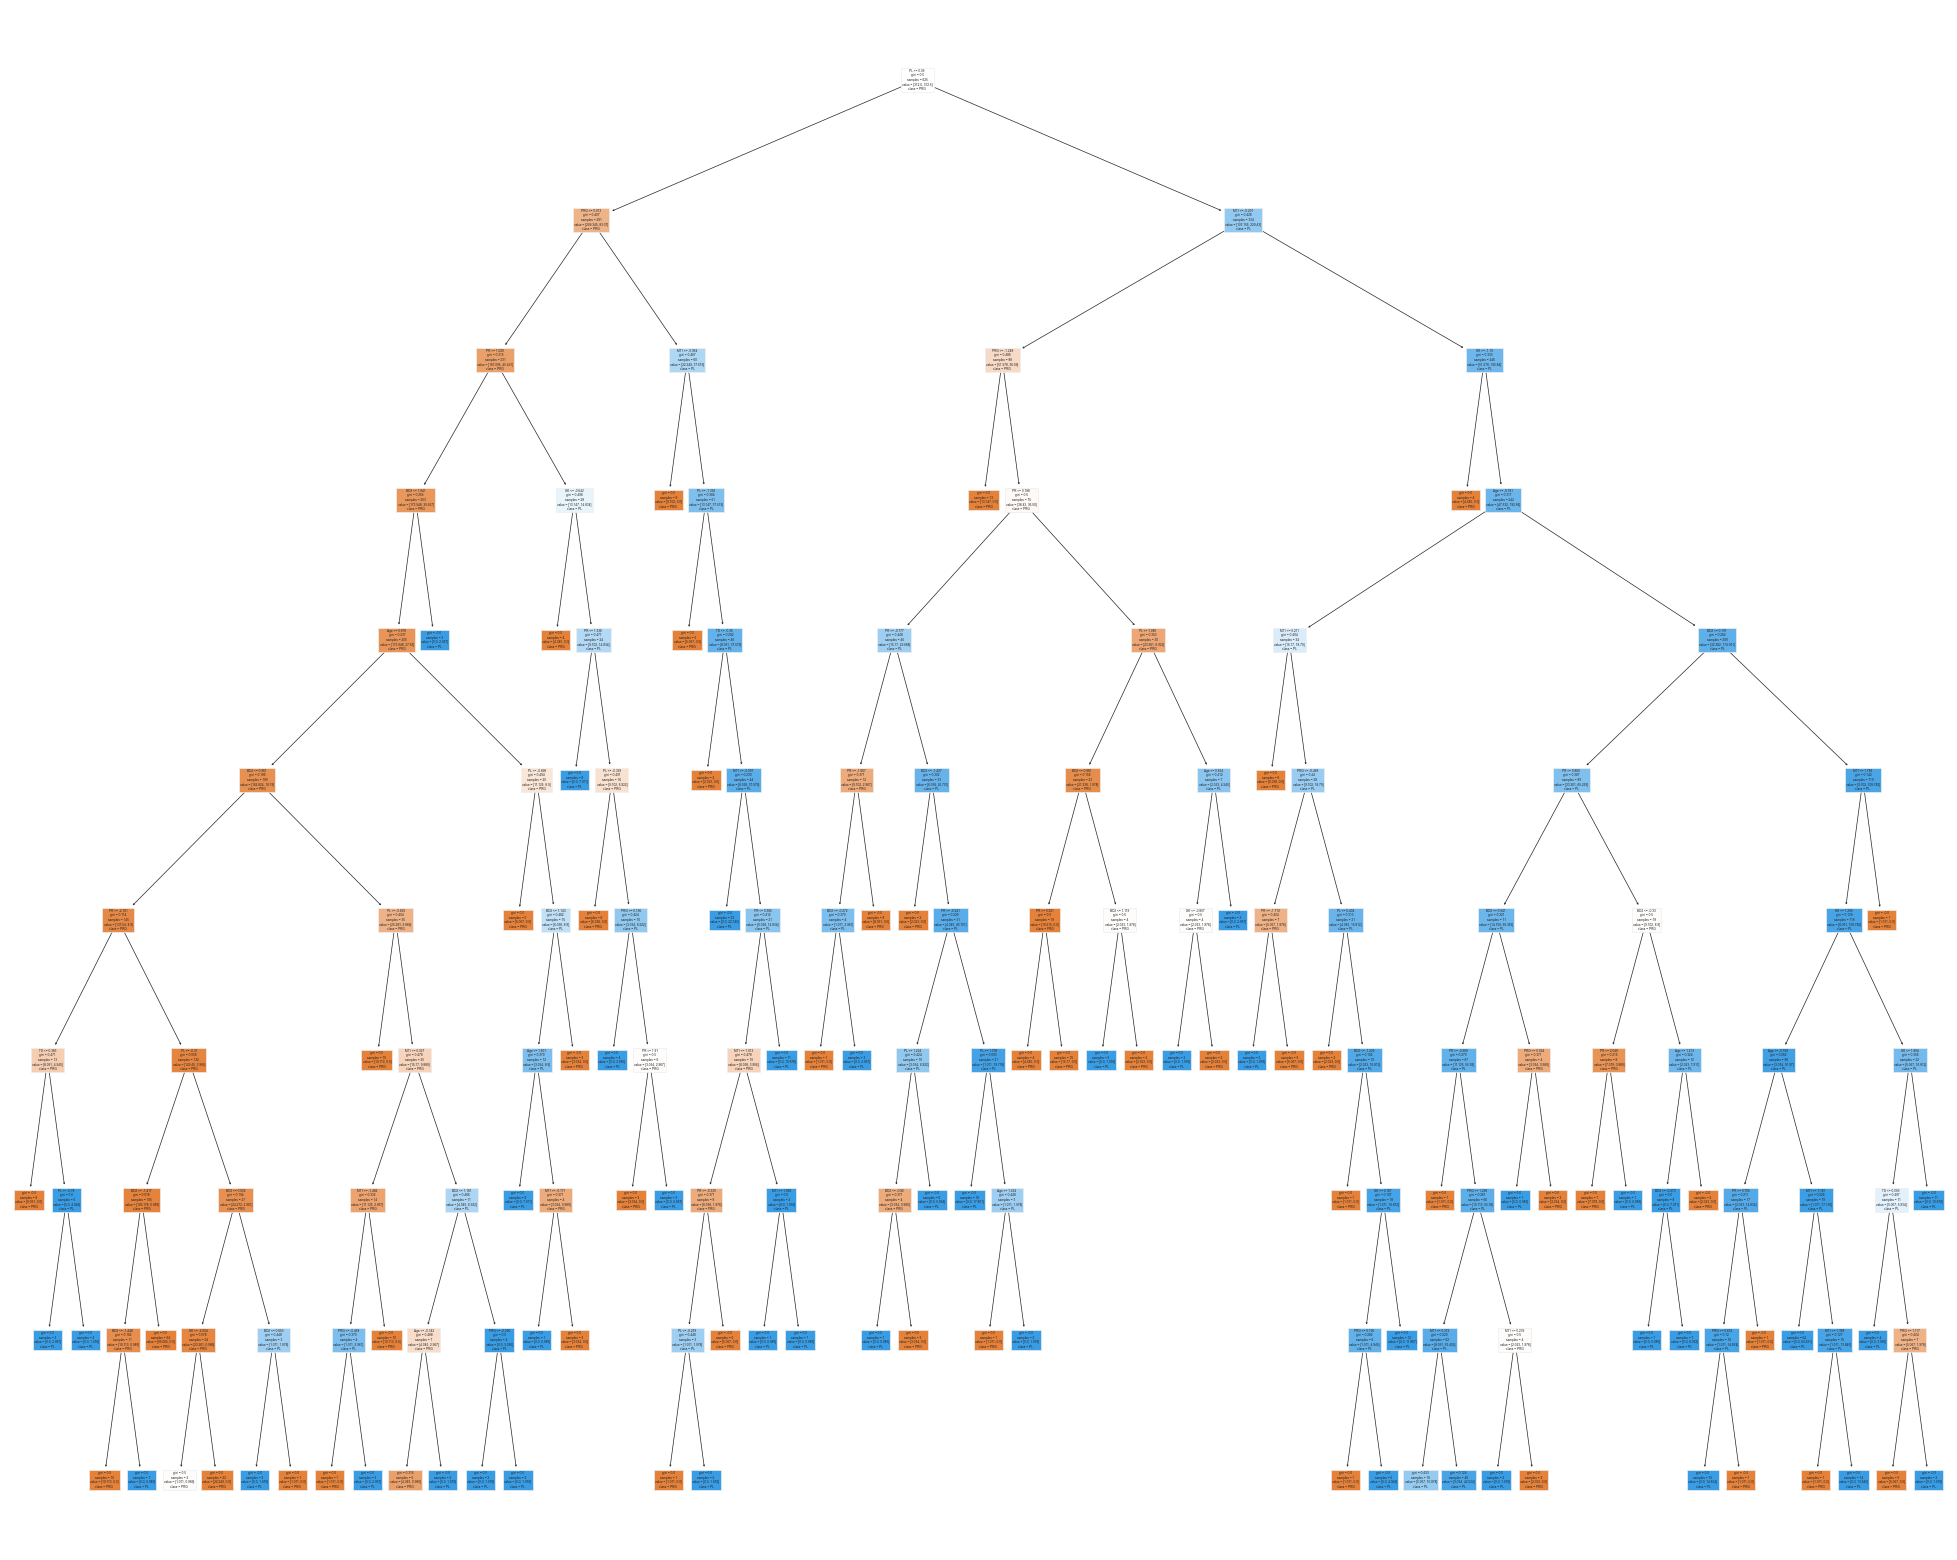

In [8]:
fig, ax = plt.subplots(figsize=(25,20))
tree.plot_tree(
    tree_clf.best_estimator_,
    feature_names=['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'],
    class_names=['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'],
    filled=True, ax=ax
)

In [9]:
bagged_trees_params = {
    "n_estimators": np.arange(10, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

base_clf_trees = BaggingClassifier(
    estimator=tree_clf.best_estimator_,
    random_state=0, # Reproducible result
    n_jobs=-2
)

trees_clf = GridSearchCV(
    base_clf_trees,
    bagged_trees_params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
trees_clf.fit(train_X, train_y.values.ravel())

GridSearchCV(estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                          max_depth=10,
                                                                          random_state=0),
                                         n_jobs=-2, random_state=0),
             n_jobs=-2,
             param_grid={'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'n_estimators': array([10, 15, 20])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [10]:
trees_clf.best_params_

{'max_samples': 0.9, 'n_estimators': 15}

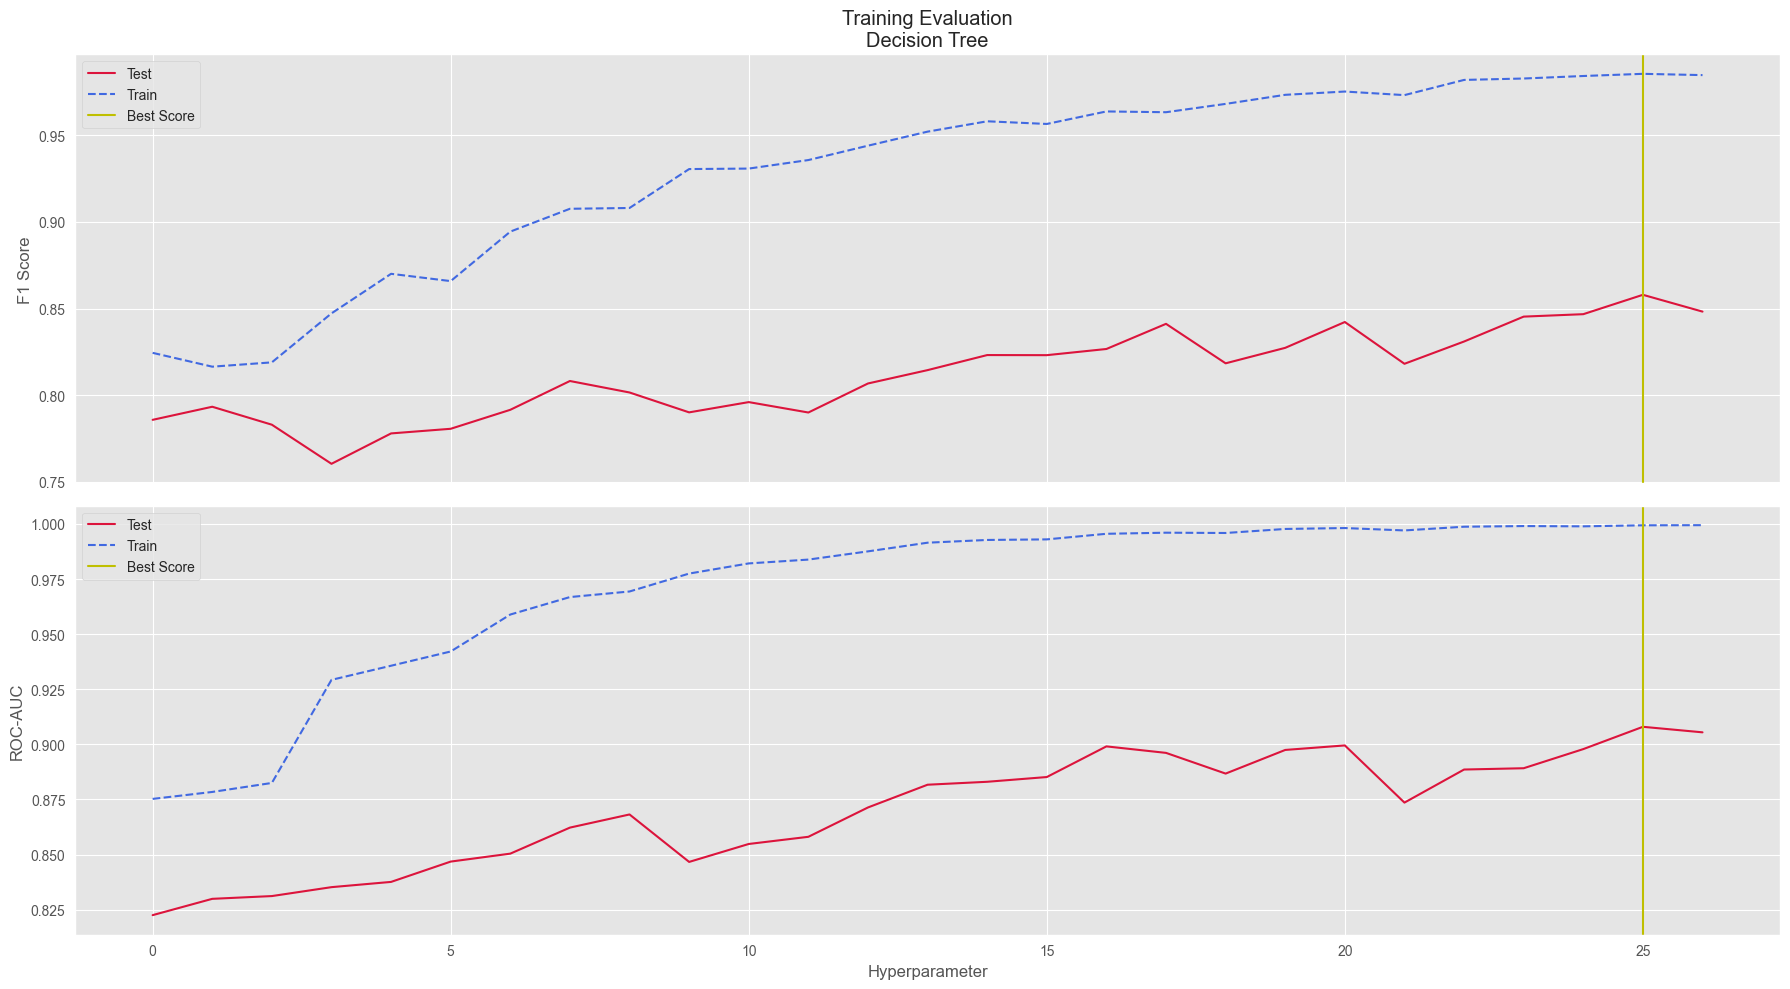

In [11]:
visualize_training(trees_clf, "Training Evaluation\nDecision Tree", "../images/Optimization_BaggedTrees_TrainValCompare.png")

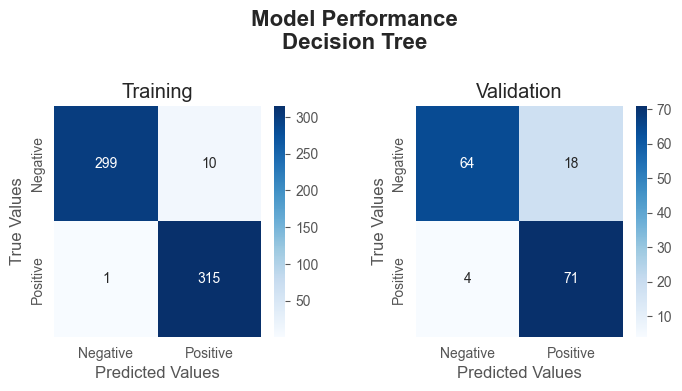

╔═══════════════════════════════════════════════════╗
║               TRAINING PERFORMANCE                ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       309
         1.0       0.97      1.00      0.98       316

    accuracy                           0.98       625
   macro avg       0.98      0.98      0.98       625
weighted avg       0.98      0.98      0.98       625

╔═══════════════════════════════════════════════════╗
║              VALIDATION PERFORMANCE               ║
╚═══════════════════════════════════════════════════╝
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85        82
         1.0       0.80      0.95      0.87        75

    accuracy                           0.86       157
   macro avg       0.87      0.86      0.86       157
weighted avg       0.87      0.86      0.86       157



In [12]:
train_pred_y = trees_clf.predict(train_X)
val_pred_y = trees_clf.predict(val_X)
show_train_val_confusion_matrix(train_y, train_pred_y, val_y, val_pred_y, "Model Performance\nDecision Tree", "../images/Optimization_BaggedTrees_CM.png")

## 2. Prediction

In [13]:
export_path = "../data/out/s3877562_predictions.csv"

df_test_original = pd.read_csv("../data/Paitients_Files_Test.csv")
patient_id = df_test_original["ID"].values

pred_y = trees_clf.predict(df_test)
pred_y = np.where(pred_y == 0.0, "Negative", "Positive")

df_export = pd.DataFrame({"ID": patient_id, "Sepssis": pred_y})

In [14]:
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ID       169 non-null    object
 1   Sepssis  169 non-null    object
dtypes: object(2)
memory usage: 2.8+ KB


In [15]:
df_export.head()

,ID,Sepssis
0,ICU200609,Negative
1,ICU200610,Negative
2,ICU200611,Negative
3,ICU200612,Positive
4,ICU200613,Positive


In [16]:
df_export.to_csv(export_path, index=False)